<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>
This is my color style for this notebook:)
- <r>Red</r> 
- <o>Orange</o> 
- <g>Green</g> 

# Introduction
Welcome to Practical 4 for Graph Representation Learning. In this practical, we will focus on the over-smoothing phenomenon described in the lectures. We will be using [PyTorch](https://pytorch.org/docs/stable/index.html) and [PyG](https://pytorch-geometric.readthedocs.io/en/latest/) for our experiments.

The notebook is divided into sections, each of which comes with complete or partially completed code. Before each snippet of code there will be a description of what we are about to implement. The sections of code you need to complete are marked as **Tasks**.

Please ensure that you operate within the framework given in the notebook and bring any questions you may have to the practical demonstrators. We suggest that you **DO NOT** edit code that is a part of the framework, since this will make it more difficult for demonstrators to assist if your code is broken.

Since we are working in a Jupyter Notebook, the code is very interactive. When you're stuck on something, try adding a new block of code below what you're working on and using it to debug your code.

###Part 0. Set up dependencies
Run the following blocks of code to install the required packages.

In [1]:
!python -c "import torch; print(torch.__version__)"

2.5.1


In [2]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Part 1. Oversmoothing

This part aims to investigate oversmoothing: we will consider different number of layers and visualise the corresponding node embeddings. Specifically, we will experiment using the following dataset and methods:

1.   Dataset: CORA
2.   Model: Graph Convolutional Network
3.   Dimensionality reduction method: T-SNE

### A. Model Implementation and Training

#### a. Import required packages

Please run the below code block to import the required python packages. It is recommended to use `GCNConv` layer from `torch_geometric.nn` as we had already implemented GNN from scratch in **Practical 2**. If you prefer to use your own GCN layer, please make sure it works within the pre-defined framework below.

In [3]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv

from torch.optim import Adam
from sklearn.metrics import accuracy_score

c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\typing.py:98: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


#### b. Load CORA dataset

We will use `torch_geometric.datasets` to load the `Cora` dataset for node classification, which consists of 2,708 nodes, 10,556 edges, 1,433 features, and 7 classes.

In [4]:
dataset = datasets.Planetoid(
		root="./",
		name='Cora',
		split="public",
		transform=torch_geometric.transforms.GCNNorm()
	)
print(dataset.data)
print(type(dataset))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
<class 'torch_geometric.datasets.planetoid.Planetoid'>


c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


**Note that Cora dataset only contains a single graph**
- `dataset.data.x` : input node features
	- $2708$ nodes
	- $1433$ feature dimension

- `dataset.data.edge_index` : A sparce adjacent matrix with the size of $2 \times n$ edge; $n$ is the number of edges in this graph

- `dataset.data.y` : target labels

- `dataset.data.train_mask` : boolean mask indicating whether an index belongs to training data

- `dataset.data.val_mask` : boolean mask indicating whether an index belongs to validation data

- `dataset.data.test_mask` : boolean mask indicating whether an index belongs to test data

In [5]:
# Indeed, the number of classes in Cora dataset is 7
torch.unique(dataset.data.y).size(0)

7

<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>

<o>
Breakdown of Node Allocation in Cora:

- Training Set (140 nodes): These nodes are labeled and used to compute the loss during training.

- Validation Set (500 nodes): These nodes are used to tune hyperparameters (e.g., learning rate, dropout rate) and monitor for overfitting.

- Test Set (1000 nodes): These nodes are held out entirely during training and validation and are used to evaluate the final performance of the model.

- Remaining Nodes (1068 nodes): These nodes are:

- Unlabeled in the dataset but are part of the graph's topology (features and connections).
	- Provide neighborhood information during the message-passing phase for labeled nodes.
	- Indirectly influence the learned representations.</o>


In [6]:
print(dataset.data.train_mask.sum())
print(dataset.data.val_mask.sum())
print(dataset.data.test_mask.sum())

tensor(140)
tensor(500)
tensor(1000)


In [7]:
def partition_edge_index(edge_index, train_mask):
	"""Partitions the edge_index tensor using the train_mask.

	Args:
		edge_index: A tensor of size [2, num_edges] representing the edges.
		train_mask: A boolean tensor indicating the nodes in the training set.

	Returns:
		A tensor of size [2, *] where * is the number of edges such that both
		end nodes are in the train_mask.
	"""

	# Get the indices of the nodes in the training set.
	#.nonzero() outputs a column tensor of node IDs and we need to squeeze it (remove dim 1 component)
	train_nodes = train_mask.nonzero().squeeze()

	# Check if both end nodes of each edge are in the training set.
	# edge_index[0]: source nodes of edges
	# edge_index[1]: target nodes of edges
	# isin(): Checks if elements of edge_index are in train_nodes
	# mask is of size 10556
	mask = torch.isin(edge_index[0], train_nodes) & torch.isin(edge_index[1], train_nodes)
	# Select the edges where both end nodes are in the training set.
	partitioned_edge_index = edge_index[:, mask]

	return partitioned_edge_index

# Example usage with your data structure:
edge_index = dataset.data.edge_index
train_mask = dataset.data.train_mask
partitioned_edge_index = partition_edge_index(edge_index, train_mask)
# print(f'Among the 10556 edges in the Cora dataset, only {partitioned_edge_index.size()[1]} of them are entirely in the training set.')

# partitioned_edge_index now contains the desired edges.

In [8]:
# Check nonzero() method and squeeze() method
boolean_tensor = torch.tensor([True, False, True, False])
print(boolean_tensor.nonzero())
print(boolean_tensor.nonzero().squeeze())

tensor([[0],
        [2]])
tensor([0, 2])


In [9]:
# Check isin() method
torch.isin(torch.tensor([[1, 2], [3, 4]]), torch.tensor([2, 3]))

tensor([[False,  True],
        [ True, False]])

In [10]:
# isin() returns a tensor of same size, so here it's 2D
my_mask = torch.isin(torch.tensor([[1, 2, 3, 4]]), torch.tensor([2, 3])).squeeze()
my_tensor = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8]])
my_tensor[:, my_mask]

tensor([[2, 3],
        [6, 7]])

In [11]:
# NB: That's why we don't need squeeze() for the isin() method in the edge partition function
dataset.data.edge_index[0].size()

torch.Size([10556])

#### c. Task 1) Setup graph convolutional network for node classification
Define a GCN class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


In [12]:
class GCN(nn.Module):
	def __init__(
			self,
			input_dim: int,
			hid_dim: int,
			n_classes: int,
			n_layers: int, # To be precise, this is the number of GCN
			dropout_ratio: float = 0.3):
		super(GCN, self).__init__()
		"""
		Args:
			input_dim: input feature dimension
			hid_dim: hidden feature dimension
			n_classes: number of target classes
			n_layers: number of layers
			dropout_ratio: dropout_ratio
		"""
		## ------ Begin Solution ------ ##
		self.n_layers = n_layers
		self.dropout_ratio = dropout_ratio

		# In each case, the shape of the output tensor is [input_dim, n_classes]
		if self.n_layers == 0:
				# Single fully-connected MLP
				self.fc = nn.Linear(input_dim, n_classes)
		elif self.n_layers == 1:
				# Single GCN layer + fully-connected MLP
				self.gcn = GCNConv(input_dim, hid_dim)
				self.fc_out = nn.Linear(hid_dim, n_classes)
		else:
				# Create a list of GCN layers
				self.gcns = nn.ModuleList()
				self.gcns.append(GCNConv(input_dim, hid_dim))  # First GCN layer: input -> hidden
				for _ in range(n_layers - 1):
						self.gcns.append(GCNConv(hid_dim, hid_dim))  # Subsequent GCN layers: hidden -> hidden
				self.fc_out = nn.Linear(hid_dim, n_classes)  # Final MLP layer: hidden -> output (n_classes)
		## ------ End Solution ------ ##

	# Return a logtis tensor of shape [#nodes, #classes]
	def forward(self, X, A) -> torch.Tensor:
		## ------ Begin Solution ------ ##
		x = X
		if self.n_layers == 0:
			logits = self.generate_node_embeddings(x, A)
		elif self.n_layers == 1:
			embedding = self.generate_node_embeddings(x, A)
			logits = self.fc_out(embedding)
		else:
			embedding = self.generate_node_embeddings(x, A)
			logits = self.fc_out(embedding)
		return logits
		## ------ End Solution ------ ##

	# Return an embedding tensor of shape [#nodes, #hidden_dim]
	def generate_node_embeddings(self, X, A) -> torch.Tensor:
		## ------ Begin Solution ------ ##
		x = X
		if self.n_layers == 0:
			embedding = self.fc(x)
		elif self.n_layers == 1:
			embedding = self.gcn(x, A)
		else:
			for gcn in self.gcns:
				# Don't apply nonlinear activation and dropout for generating the embedding
				embedding = x
				x = F.relu(gcn(x, A))
				# Note that self.training is inherited from nn.Module
				x = F.dropout(x, p=self.dropout_ratio, training=self.training)  # Dropout
		# Note that here we exclude the output layer (final GCN layer)
		return embedding
		## ------ End Solution ------ ##

	def param_init(self):
		## ------ Begin Solution ------ ##
		for param in self.parameters():
			if param.dim() > 1:  # Check for weight parameters
				nn.init.xavier_uniform_(param)  # Xavier initialization for weights
			else:
				nn.init.zeros_(param)  # Initialize biases to zero
		## ------ End Solution ------ ##

#### c. Task 2) Implement `train` and `evaluate` functions for training a node classification model.

- Apply **Early-stopping**: stop training if the validation accuracy decreases during *k* consecutive epochs.
- Use **Adam optimizer** for training.
- Use **evaluate** function for calculating the validation accuracy in every epoch to adapt early-stopping.

Please note that `train` function should return the trained model object and `evaluate` function should return a validation accuracy.

<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>
<o> **NB:**
In the following codes, I use the entire graph in the forward pass. This is because of the atypical nature of node classification task which is often refered as *semi-supervised learning*. This terminology is used because when we are training node classification models, we usually have access to the full graph, including all the unlabeled (e.g., test) nodes. The only thing we are missing is the labels of test nodes. However, we can still use information about the test nodes (e.g., knowledge of their neighborhood in the graph) to improve our model during training. This is different from the usual supervised setting, in which unlabeled datapoints are completely unobserved during training.</o>

In [13]:
def train(
		params: typing.Dict
) -> torch.nn.Module:
	"""
		This function trains a node classification model and returns the trained model object.
	"""
	# set device
	device = "cuda" if torch.cuda.is_available() else "cpu"
	
	# load dataset
	data = dataset.data
	data = data.to(device)

	# Update parameters
	params["n_classes"] = dataset.num_classes # number of target classes
	params["input_dim"] = dataset.num_features # size of input features

	# Set a model
	if params['model_name'] == 'GCN':
			model = GCN(
				params["input_dim"],
				params["hid_dim"],
				params["n_classes"],
				params["n_layers"]
				).to(device)
	elif params['model_name'] == 'SkipGCN':
			model = SkipGCN(
				params["input_dim"],
				params["hid_dim"],
				params["n_classes"],
				params["n_layers"]
			).to(device)
	elif params['model_name'] == 'JumpKnowGCN':
			model = JumpKnowGCN(
				params["input_dim"],
				params["hid_dim"],
				params["n_classes"],
				params["n_layers"]
			).to(device)
	else:
			raise NotImplementedError

	model.param_init() # Initialize model parameters

	## ------ Begin Solution ------ ##
	# Adam optimizer and loss function
	optimizer = Adam(model.parameters(), lr=params["lr"])
	criterion = torch.nn.CrossEntropyLoss()

	best_val_acc = 0.0  # Best validation accuracy seen so far
	early_stop_count = 0  # Count of consecutive epochs with no improvement
	max_early_stop = params["max_patience"]  # Early stop patience (k)
	num_epochs = params["epochs"]  # Number of training epochs

	for epoch in range(num_epochs):
		model.train()  # Set the model to training mode
		optimizer.zero_grad()  # Clear previous gradients

		# Forward pass: Compute predicted outputs by passing data through the model
		# NB: In the context of semi-supervised learning, we use the entire graph
		out = model(data.x, data.edge_index)

		# Compute the loss for the training nodes
		loss = criterion(out[data.train_mask], data.y[data.train_mask]) # A scalar tensor

		# Backward pass: Compute gradients and update the weights
		loss.backward()
		optimizer.step()

		# Validation accuracy calculation
		model.eval()  # Set model to evaluation mode
		with torch.no_grad():  # Disable gradient computation during evaluation
			# val_out is of shape [#nodes, #classes]
			val_out = model(data.x, data.edge_index)  # Get validation logits
			# torch.argmax: https://pytorch.org/docs/stable/generated/torch.argmax.html#torch-argmax
			val_preds = val_out.argmax(dim=1)  # Predicted classes of shape [#classes]
			val_correct = (val_preds[data.val_mask] == data.y[data.val_mask]).sum().item()
			val_total = data.val_mask.sum().item()
			val_acc = val_correct / val_total if val_total > 0 else 0.0

		print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Accuracy: {val_acc:.4f}")

		# Early stopping logic
		if val_acc > best_val_acc:
			best_val_acc = val_acc
			early_stop_count = 0  # Reset counter if accuracy improves
		else:
			early_stop_count += 1

		if early_stop_count >= max_early_stop:
			print(f"Early stopping triggered at epoch {epoch+1}")
			break

	return model
	## ------ End Solution ------ ##

In [14]:
def evaluate(
	model,
	data,
	mask_type
):
	## ------ Begin Solution ------ ##

	"""
	Evaluate the model on a specific mask (train, validation, or test) and return accuracy.

	Args:
		model: Trained model.
		data: Dataset containing node features, edge indices, and masks.
		mask_type: Type of mask to evaluate ('train', 'val', 'test').
		device: Device used for evaluation.

	Returns:
		Accuracy as a float.
	"""

	assert mask_type in ['train', 'val', 'test'], "mask_type must be 'train', 'val', or 'test'"
	mask = getattr(data, f"{mask_type}_mask")  # Get the mask based on mask_type

	model.eval()  # Set model to evaluation mode
	with torch.no_grad():  # Disable gradient computation during evaluation
		out = model(data.x, data.edge_index)  # Get logits
		preds = out.argmax(dim=1)  # Predicted classes
		correct = (preds[mask] == data.y[mask]).sum().item()  # Count correct predictions
		total = mask.sum().item()  # Total samples in mask
		accuracy = correct / total if total > 0 else 0.0

	return accuracy

	## ------ End Solution ------ ##

#### d. Set training hyper-parameters

In [15]:
training_params = {
	"lr": 0.005,  # learning rate
	"weight_decay": 0.0005,  # weight_decay
	"epochs": 100,  # number of total training epochs
	"max_patience": 5, # number of k for early stopping
	"hid_dim": 64, # size of hidden features
	"n_layers": None, # number of layers
	"model_name": "GCN"
}


#### e. Train 4 GCN models with 0, 1, 3 and 10 layers.

In [16]:
torch.manual_seed(123) # set seed

In [17]:
training_params["n_layers"] = 0
model_0_layer = train(training_params)

Epoch 1/100, Loss: 1.9578, Val Accuracy: 0.1920
Epoch 2/100, Loss: 1.8554, Val Accuracy: 0.2320
Epoch 3/100, Loss: 1.7555, Val Accuracy: 0.2820
Epoch 4/100, Loss: 1.6584, Val Accuracy: 0.3220
Epoch 5/100, Loss: 1.5642, Val Accuracy: 0.3460
Epoch 6/100, Loss: 1.4733, Val Accuracy: 0.3680
Epoch 7/100, Loss: 1.3857, Val Accuracy: 0.3800
Epoch 8/100, Loss: 1.3017, Val Accuracy: 0.4060
Epoch 9/100, Loss: 1.2215, Val Accuracy: 0.4220
Epoch 10/100, Loss: 1.1451, Val Accuracy: 0.4260
Epoch 11/100, Loss: 1.0728, Val Accuracy: 0.4380
Epoch 12/100, Loss: 1.0044, Val Accuracy: 0.4340
Epoch 13/100, Loss: 0.9402, Val Accuracy: 0.4380
Epoch 14/100, Loss: 0.8799, Val Accuracy: 0.4480
Epoch 15/100, Loss: 0.8236, Val Accuracy: 0.4500
Epoch 16/100, Loss: 0.7711, Val Accuracy: 0.4480
Epoch 17/100, Loss: 0.7223, Val Accuracy: 0.4560
Epoch 18/100, Loss: 0.6771, Val Accuracy: 0.4540
Epoch 19/100, Loss: 0.6352, Val Accuracy: 0.4600
Epoch 20/100, Loss: 0.5966, Val Accuracy: 0.4620
Epoch 21/100, Loss: 0.5609, V

In [18]:
training_params["n_layers"] = 1
model_1_layer = train(training_params)

Epoch 1/100, Loss: 1.9729, Val Accuracy: 0.4200
Epoch 2/100, Loss: 1.6627, Val Accuracy: 0.5620
Epoch 3/100, Loss: 1.3815, Val Accuracy: 0.6420
Epoch 4/100, Loss: 1.1292, Val Accuracy: 0.6880
Epoch 5/100, Loss: 0.9088, Val Accuracy: 0.7080
Epoch 6/100, Loss: 0.7219, Val Accuracy: 0.7120
Epoch 7/100, Loss: 0.5673, Val Accuracy: 0.7180
Epoch 8/100, Loss: 0.4419, Val Accuracy: 0.7280
Epoch 9/100, Loss: 0.3417, Val Accuracy: 0.7320
Epoch 10/100, Loss: 0.2625, Val Accuracy: 0.7360
Epoch 11/100, Loss: 0.2007, Val Accuracy: 0.7380
Epoch 12/100, Loss: 0.1529, Val Accuracy: 0.7320
Epoch 13/100, Loss: 0.1164, Val Accuracy: 0.7260
Epoch 14/100, Loss: 0.0888, Val Accuracy: 0.7240
Epoch 15/100, Loss: 0.0680, Val Accuracy: 0.7240
Epoch 16/100, Loss: 0.0524, Val Accuracy: 0.7260
Early stopping triggered at epoch 16


In [19]:
training_params["n_layers"] = 3
model_3_layer = train(training_params)

Epoch 1/100, Loss: 1.9454, Val Accuracy: 0.2600
Epoch 2/100, Loss: 1.8940, Val Accuracy: 0.5140
Epoch 3/100, Loss: 1.8117, Val Accuracy: 0.5980
Epoch 4/100, Loss: 1.7268, Val Accuracy: 0.6440
Epoch 5/100, Loss: 1.6249, Val Accuracy: 0.6660
Epoch 6/100, Loss: 1.5004, Val Accuracy: 0.6900
Epoch 7/100, Loss: 1.3311, Val Accuracy: 0.7160
Epoch 8/100, Loss: 1.1668, Val Accuracy: 0.7300
Epoch 9/100, Loss: 1.0126, Val Accuracy: 0.7540
Epoch 10/100, Loss: 0.8717, Val Accuracy: 0.7700
Epoch 11/100, Loss: 0.7292, Val Accuracy: 0.7760
Epoch 12/100, Loss: 0.6003, Val Accuracy: 0.7880
Epoch 13/100, Loss: 0.4992, Val Accuracy: 0.7820
Epoch 14/100, Loss: 0.4152, Val Accuracy: 0.7820
Epoch 15/100, Loss: 0.2919, Val Accuracy: 0.7900
Epoch 16/100, Loss: 0.2125, Val Accuracy: 0.7940
Epoch 17/100, Loss: 0.1816, Val Accuracy: 0.7940
Epoch 18/100, Loss: 0.1222, Val Accuracy: 0.7880
Epoch 19/100, Loss: 0.1231, Val Accuracy: 0.7840
Epoch 20/100, Loss: 0.0865, Val Accuracy: 0.7860
Epoch 21/100, Loss: 0.0586, V

In [20]:
training_params["n_layers"] = 10
model_10_layer = train(training_params)

Epoch 1/100, Loss: 1.9462, Val Accuracy: 0.1740
Epoch 2/100, Loss: 1.9460, Val Accuracy: 0.4540
Epoch 3/100, Loss: 1.9409, Val Accuracy: 0.1220
Epoch 4/100, Loss: 1.9239, Val Accuracy: 0.1220
Epoch 5/100, Loss: 1.9069, Val Accuracy: 0.2700
Epoch 6/100, Loss: 1.8529, Val Accuracy: 0.4360
Epoch 7/100, Loss: 1.7916, Val Accuracy: 0.3220
Early stopping triggered at epoch 7


### B. Visualisation

We will generate node embeddings, reduce their dimensions, and finally visualsie these embeddings: we expect to empirically observe that the embeddings become more and more similar with more layers.

Please use the **validation dataset** for the visualisation.

#### a. Import required packages

In [21]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

#### b. Task 3) Implement a function for demensionality reduction

- The `dimension_reduction` function will take a model object and data, perform T-SNE, and return a *DataFrame* that contains reduced variables and labels for each data point.
- Please reduce the dimension to 2d.
- Use validation data for the visualisation

You may refer this address below using T-SNE:
[Link to sklearn T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [22]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
	"""
		Args:
			model: model object for generating features

		Return:
			pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
	"""
	## ------ Begin Solution ------ ##

	# set device
	device = "cuda" if torch.cuda.is_available() else "cpu"

	# load dataset
	data = dataset.data
	data = data.to(device)

	# Set the model to evaluation mode
	model.eval()

	# Generate node embeddings
	with torch.no_grad():
			embeddings = model.generate_node_embeddings(data.x, data.edge_index)

	# Use validation data only
	val_mask = data.val_mask  # Get the validation mask
	# cpu: Ensure compatibility with NumPy, which only works with CPU data.
	# val_embeddings of shape [#validation nodes, #hidden_dim]
	val_embeddings = embeddings[val_mask].cpu().numpy()  # Select embeddings for validation nodes
	val_labels = data.y[val_mask].cpu().numpy()  # Validation labels

	# Perform dimensionality reduction using T-SNE
	reduced_embeddings = TSNE(n_components=2, random_state=42, method='exact').fit_transform(val_embeddings)

	# Create a DataFrame with reduced dimensions and labels
	df = pd.DataFrame({
			'dimension 1': reduced_embeddings[:, 0],
			'dimension 2': reduced_embeddings[:, 1],
			'labels': val_labels
	})

	return df

	## ------ End Solution ------ ##

#### c. Generate reduced embeddings for each model and save them in a dictionary object

In [23]:
feature_dict = {
	"0_layer": dimension_reduction(model_0_layer),
	"1_layer": dimension_reduction(model_1_layer),
	"3_layer": dimension_reduction(model_3_layer),
	"10_layer": dimension_reduction(model_10_layer),
}

c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packa

#### d. Task 4) Implement a function for the visualisation and draw scatter plots

- Using `matplotlib` package is recommended, but you may use any other tool.
- Please refer to this page if you are not familar with the visualisation tool: [Link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

In [24]:
# Check Pandas DataFrame

data = {
	'name': ['Alice', 'Bob', 'Charlie', 'David', 'Eva'],
	'age': [25, 35, 30, 40, 22],
	'city': ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix']
}

df = pd.DataFrame(data)

filtered_df = df[df['age'] > 30]
print(df)
print(df['age'] > 30)
print(filtered_df)



      name  age         city
0    Alice   25     New York
1      Bob   35  Los Angeles
2  Charlie   30      Chicago
3    David   40      Houston
4      Eva   22      Phoenix
0    False
1     True
2    False
3     True
4    False
Name: age, dtype: bool
    name  age         city
1    Bob   35  Los Angeles
3  David   40      Houston


In [25]:
def visualise(feature_dict: typing.Dict) -> None:
	## ------ Begin Solution ------ ##
	# Set up the figure and axes for subplots
	num_models = len(feature_dict)
	# figsize = (width, height)
	fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5), sharex=True, sharey=True)
	fig.suptitle("T-SNE Visualization of Node Embeddings", fontsize=16)

	# Iterate over the models in the dictionary
	for i, (model_name, df) in enumerate(feature_dict.items()):
		ax = axes[i] if num_models > 1 else axes  # Handle case of single plot
		ax.set_title(model_name, fontsize=14)

		# Scatter plot each class
		for label in df['labels'].unique():
			subset = df[df['labels'] == label]
			ax.scatter(
				subset['dimension 1'],
				subset['dimension 2'],
				label=f"Class {label}",
				# alpha=0.7: Sets the transparency of the points (the higher the value, the more opaque the points).
				alpha=0.7
			)

		ax.set_xlabel("Dimension 1")
		ax.set_ylabel("Dimension 2")
		# ax.legend(loc="best") places the legend in the most optimal position based on the plot content
		ax.legend(loc="best", fontsize=8)

	# Adjust layout
	plt.tight_layout(rect=[0, 0, 1, 0.96])
	plt.show()
	## ------ End Solution ------ ##

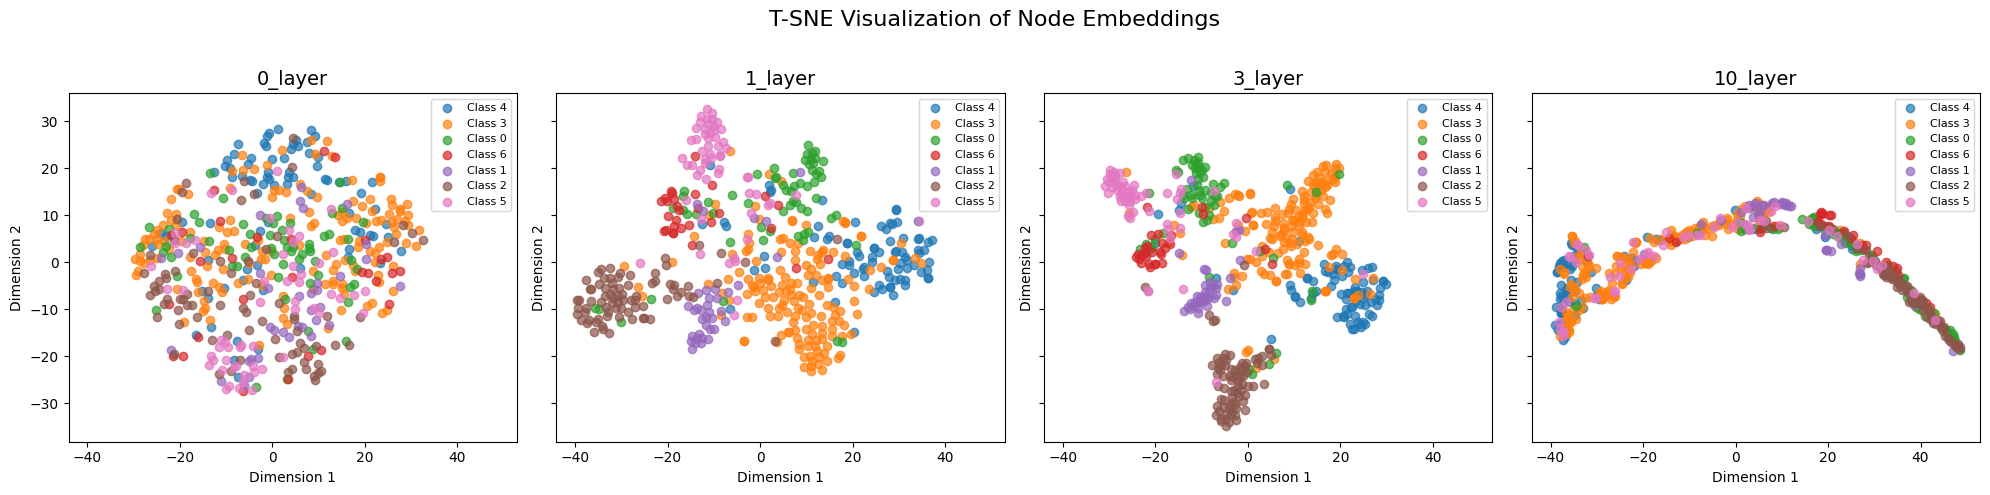

In [26]:
visualise(feature_dict)

## Part 2. Skip-Connections

In this section, we will investigate whether skip-connections can alleviate the effect of over-smoothing.

#### a. Task 5) Setup graph convolutional network with skip-connections
Define a SkipGCN class for node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using **residual connection** is recommended, but you may also use other techniques, like **concatenation**.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


In [27]:
# This is the summation implementation of skip connection, though one can easily extend this to a concatenation version
class SkipGCN(nn.Module):
	def __init__(
			self,
			input_dim: int,
			hid_dim: int,
			n_classes: int,
			n_layers: int,
			dropout_ratio: float = 0.3):
		super(SkipGCN, self).__init__()

		## ------ Begin Solution ------ ##
		self.n_layers = n_layers
		self.dropout_ratio = dropout_ratio

		# In each case, the shape of the output tensor is [input_dim, n_classes]
		if self.n_layers == 0:
				# Single fully-connected MLP
				self.fc = nn.Linear(input_dim, n_classes)
		elif self.n_layers == 1:
				# Single GCN layer + fully-connected MLP
				self.gcn = GCNConv(input_dim, hid_dim)
				self.fc_out = nn.Linear(hid_dim, n_classes)
		else:
			self.skip_gcns = nn.ModuleList()
			self.skip_gcns.append(GCNConv(input_dim, hid_dim))
			for _ in range(n_layers - 1):
					self.skip_gcns.append(GCNConv(hid_dim, hid_dim))
			self.fc_out = nn.Linear(hid_dim, n_classes)
			# Projection layer to match dimensions for skip connections
			self.projection = nn.Linear(input_dim, hid_dim) if input_dim != hid_dim else None
		## ------ End Solution ------ ##

	# Return a logtis tensor of shape [#nodes, #classes]
	def forward(self, X, A) -> torch.Tensor:
		## ------ Begin Solution ------ ##
		x = X
		if self.n_layers == 0:
			logits = self.generate_node_embeddings(x, A)
		# No skip connection in the last layer simply for convenience
		elif self.n_layers == 1:
			embedding = self.generate_node_embeddings(x, A)
			logits = self.fc_out(embedding)
		else:
			embedding = self.generate_node_embeddings(x, A)
			logits = self.fc_out(embedding)
		return logits
		## ------ End Solution ------ ##

	# Return an embedding tensor of shape [#nodes, #hidden_dim]
	def generate_node_embeddings(self, X, A) -> torch.Tensor:
		## ------ Begin Solution ------ ##
		x = X
		if self.n_layers == 0:
			embedding = self.fc(x)
		elif self.n_layers == 1:
			embedding = self.gcn(x, A)
		else:
			# If input and hidden dimensions differ, project input to hidden dimension
			# In Python, objects like nn.Linear are "truthy" (i.e., evaluate to True) unless explicitly set to a falsy value such as None, False, 0, or an empty collection. So, the check if self.projection effectively checks if the self.projection attribute is a valid object (i.e., if it is not None).
			skip_connection = self.projection(x) if self.projection else x
			for skip_gcn in self.skip_gcns:
				# Don't apply nonlinear activation and dropout for generating the embedding
				embedding = x
				x = F.relu(skip_gcn(x, A))
				x = F.dropout(x, p=self.dropout_ratio, training=self.training)
				x = x + skip_connection
				skip_connection = x
		return embedding
		## ------ End Solution ------ ##

	def param_init(self):
		## ------ Begin Solution ------ ##
		for param in self.parameters():
				if param.dim() > 1:
						nn.init.xavier_uniform_(param)
				else:
						nn.init.zeros_(param)
		## ------ End Solution ------ ##

#### b. Repeat experiments and Visualise the embeddings

In [28]:
torch.manual_seed(123) # set seed

In [29]:
training_params['model_name'] = 'SkipGCN'
training_params["n_layers"] = 0
model_0_layer = train(training_params)

Epoch 1/100, Loss: 1.9578, Val Accuracy: 0.1920
Epoch 2/100, Loss: 1.8554, Val Accuracy: 0.2320
Epoch 3/100, Loss: 1.7555, Val Accuracy: 0.2820
Epoch 4/100, Loss: 1.6584, Val Accuracy: 0.3220
Epoch 5/100, Loss: 1.5642, Val Accuracy: 0.3460
Epoch 6/100, Loss: 1.4733, Val Accuracy: 0.3680
Epoch 7/100, Loss: 1.3857, Val Accuracy: 0.3800
Epoch 8/100, Loss: 1.3017, Val Accuracy: 0.4060
Epoch 9/100, Loss: 1.2215, Val Accuracy: 0.4220
Epoch 10/100, Loss: 1.1451, Val Accuracy: 0.4260
Epoch 11/100, Loss: 1.0728, Val Accuracy: 0.4380
Epoch 12/100, Loss: 1.0044, Val Accuracy: 0.4340
Epoch 13/100, Loss: 0.9402, Val Accuracy: 0.4380
Epoch 14/100, Loss: 0.8799, Val Accuracy: 0.4480
Epoch 15/100, Loss: 0.8236, Val Accuracy: 0.4500
Epoch 16/100, Loss: 0.7711, Val Accuracy: 0.4480
Epoch 17/100, Loss: 0.7223, Val Accuracy: 0.4560
Epoch 18/100, Loss: 0.6771, Val Accuracy: 0.4540
Epoch 19/100, Loss: 0.6352, Val Accuracy: 0.4600
Epoch 20/100, Loss: 0.5966, Val Accuracy: 0.4620
Epoch 21/100, Loss: 0.5609, V

c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [30]:
training_params['model_name'] = 'SkipGCN'
training_params["n_layers"] = 1
model_0_layer = train(training_params)

Epoch 1/100, Loss: 1.9729, Val Accuracy: 0.4200
Epoch 2/100, Loss: 1.6627, Val Accuracy: 0.5620
Epoch 3/100, Loss: 1.3815, Val Accuracy: 0.6420
Epoch 4/100, Loss: 1.1292, Val Accuracy: 0.6880
Epoch 5/100, Loss: 0.9088, Val Accuracy: 0.7080
Epoch 6/100, Loss: 0.7219, Val Accuracy: 0.7120
Epoch 7/100, Loss: 0.5673, Val Accuracy: 0.7180
Epoch 8/100, Loss: 0.4419, Val Accuracy: 0.7280
Epoch 9/100, Loss: 0.3417, Val Accuracy: 0.7320
Epoch 10/100, Loss: 0.2625, Val Accuracy: 0.7360
Epoch 11/100, Loss: 0.2007, Val Accuracy: 0.7380
Epoch 12/100, Loss: 0.1529, Val Accuracy: 0.7320
Epoch 13/100, Loss: 0.1164, Val Accuracy: 0.7260
Epoch 14/100, Loss: 0.0888, Val Accuracy: 0.7240
Epoch 15/100, Loss: 0.0680, Val Accuracy: 0.7240
Epoch 16/100, Loss: 0.0524, Val Accuracy: 0.7260
Early stopping triggered at epoch 16


In [31]:
training_params['model_name'] = 'SkipGCN'
training_params["n_layers"] = 3
model_0_layer = train(training_params)

Epoch 1/100, Loss: 1.9560, Val Accuracy: 0.4340
Epoch 2/100, Loss: 1.3737, Val Accuracy: 0.5920
Epoch 3/100, Loss: 0.9058, Val Accuracy: 0.6520
Epoch 4/100, Loss: 0.5596, Val Accuracy: 0.6800
Epoch 5/100, Loss: 0.3255, Val Accuracy: 0.7000
Epoch 6/100, Loss: 0.1795, Val Accuracy: 0.7200
Epoch 7/100, Loss: 0.1034, Val Accuracy: 0.7260
Epoch 8/100, Loss: 0.0636, Val Accuracy: 0.7380
Epoch 9/100, Loss: 0.0322, Val Accuracy: 0.7320
Epoch 10/100, Loss: 0.0182, Val Accuracy: 0.7280
Epoch 11/100, Loss: 0.0111, Val Accuracy: 0.7340
Epoch 12/100, Loss: 0.0073, Val Accuracy: 0.7320
Epoch 13/100, Loss: 0.0043, Val Accuracy: 0.7340
Early stopping triggered at epoch 13


In [32]:
training_params['model_name'] = 'SkipGCN'
training_params["n_layers"] = 10
model_0_layer = train(training_params)

Epoch 1/100, Loss: 5.3244, Val Accuracy: 0.1260
Epoch 2/100, Loss: 2.5573, Val Accuracy: 0.2020
Epoch 3/100, Loss: 1.8258, Val Accuracy: 0.3780
Epoch 4/100, Loss: 1.5138, Val Accuracy: 0.3780
Epoch 5/100, Loss: 1.2532, Val Accuracy: 0.4300
Epoch 6/100, Loss: 1.0526, Val Accuracy: 0.5660
Epoch 7/100, Loss: 0.7347, Val Accuracy: 0.6680
Epoch 8/100, Loss: 0.5487, Val Accuracy: 0.6960
Epoch 9/100, Loss: 0.3783, Val Accuracy: 0.7080
Epoch 10/100, Loss: 0.2704, Val Accuracy: 0.7120
Epoch 11/100, Loss: 0.1501, Val Accuracy: 0.7180
Epoch 12/100, Loss: 0.0938, Val Accuracy: 0.7220
Epoch 13/100, Loss: 0.0740, Val Accuracy: 0.7260
Epoch 14/100, Loss: 0.0452, Val Accuracy: 0.7380
Epoch 15/100, Loss: 0.0244, Val Accuracy: 0.7420
Epoch 16/100, Loss: 0.0167, Val Accuracy: 0.7440
Epoch 17/100, Loss: 0.0151, Val Accuracy: 0.7500
Epoch 18/100, Loss: 0.0069, Val Accuracy: 0.7340
Epoch 19/100, Loss: 0.0037, Val Accuracy: 0.7380
Epoch 20/100, Loss: 0.0051, Val Accuracy: 0.7340
Epoch 21/100, Loss: 0.0043, V

In [33]:
feature_dict = {
	"0_layer": dimension_reduction(model_0_layer),
	"1_layer": dimension_reduction(model_1_layer),
	"3_layer": dimension_reduction(model_3_layer),
	"10_layer": dimension_reduction(model_10_layer),
}

c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packa

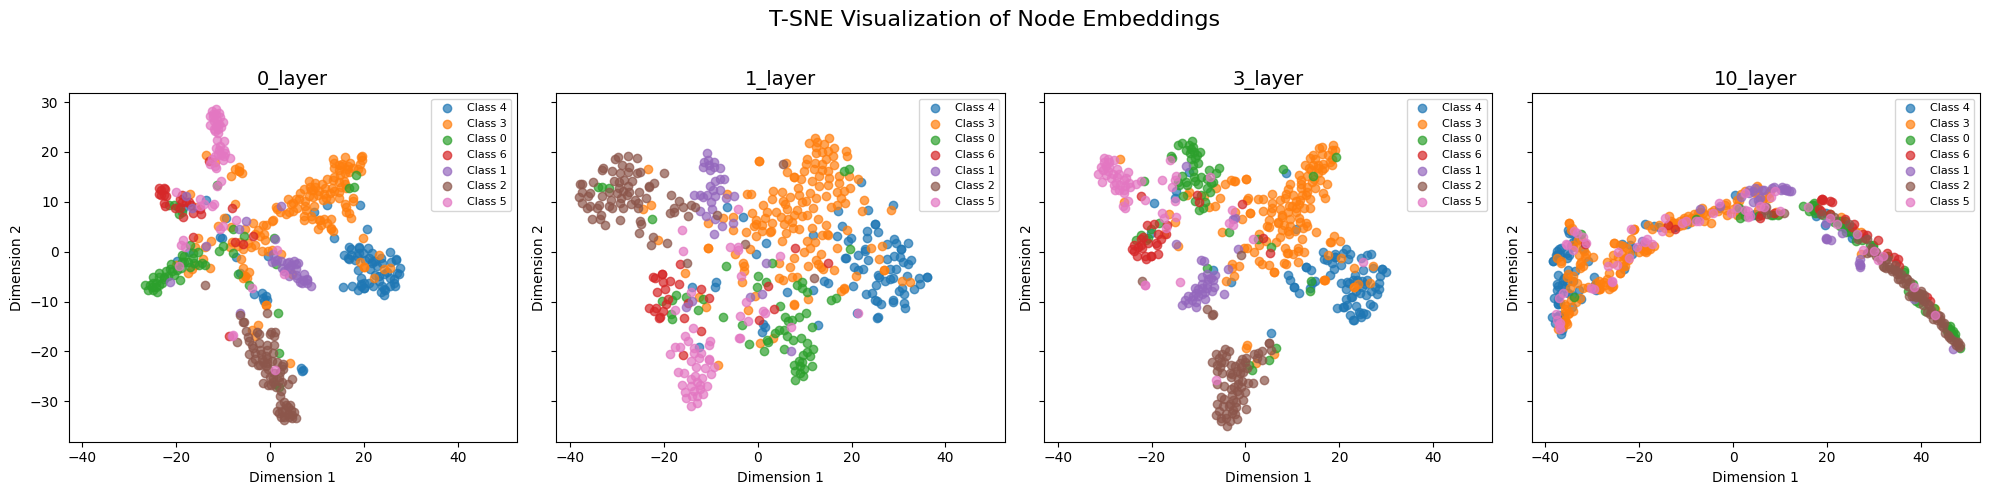

In [34]:
visualise(feature_dict)

## (Optional) Jumping Knowledge Connection

#### a. Task6) Design Graph Convolutional Network with Jumping Knowledge Connection
Define a `JumpKnowGCN` class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using `max_pooling` is recommended but you may also use other differentiable functions.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `relu` and `dropout` at the end of each layer.


<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>
<o> The Jumping Knowledge (JK) architecture from the [Representation Learning on Graphs with Jumping Knowledge Networks](https://arxiv.org/pdf/1806.03536) paper. </o>

In [35]:
class JumpKnowGCN(nn.Module):
	def __init__(
		self,
		input_dim: int,
		hid_dim: int,
		n_classes: int,
		n_layers: int,
		dropout_ratio: float = 0.3):
		super(JumpKnowGCN, self).__init__()

		## ------ Begin Solution ------ ##
		self.n_layers = n_layers
		self.hid_dim = hid_dim
		self.dropout_ratio = dropout_ratio

		# In each case, the shape of the output tensor is [input_dim, n_classes]
		if self.n_layers == 0:
				# Single fully-connected MLP
				self.fc = nn.Linear(input_dim, n_classes)
		elif self.n_layers == 1:
				# Single GCN layer + fully-connected MLP
				self.gcn = GCNConv(input_dim, hid_dim)
				self.fc_out = nn.Linear(hid_dim, n_classes)
		else:
				# Create a list of GCN layers
				self.JK_gcns = nn.ModuleList()
				self.JK_gcns.append(GCNConv(input_dim, hid_dim))  # First GCN layer: input -> hidden
				for _ in range(n_layers - 1):
						self.JK_gcns.append(GCNConv(hid_dim, hid_dim))  # Subsequent GCN layers: hidden -> hidden
				self.fc_out = nn.Linear(hid_dim, n_classes)  # Final MLP layer: hidden -> output (n_classes)
		## ------ End Solution ------ ##

	# Return a logtis tensor of shape [#nodes, #classes]
	def forward(self, X, A) -> torch.Tensor:
		## ------ Begin Solution ------ ##
		x = X
		if self.n_layers == 0:
			logits = self.generate_node_embeddings(x, A)
		elif self.n_layers == 1:
			embedding = self.generate_node_embeddings(x, A)
			logits = self.fc_out(embedding)
		else:
			embedding = self.generate_node_embeddings(x, A)
			logits = self.fc_out(embedding)
		return logits
		## ------ End Solution ------ ##

	# Return an embedding tensor of shape [#nodes, #hidden_dim]
	def generate_node_embeddings(self, X, A) -> torch.Tensor:
		## ------ Begin Solution ------ ##
		x = X
		if self.n_layers == 0:
			embedding = self.fc(x)
		elif self.n_layers == 1:
			embedding = self.gcn(x, A)
		else:
			layer_outputs = []  # To store the outputs of all GCN layers
			for JK_gcn in self.JK_gcns:
				x = JK_gcn(x, A)
				layer_outputs.append(x)  # Store layer output
				x = F.relu(x)
				x = F.dropout(x, p=self.dropout_ratio, training=self.training)  # Dropout

			# Aggregate features from all layers using max pooling
			x = torch.stack(layer_outputs, dim=0)  # Stack layer outputs: shape (n_layers, n_nodes, hid_dim)
			embedding = torch.max(x, dim=0)[0]  # Max pooling across layers: shape (n_nodes, hid_dim)
		return embedding
		## ------ End Solution ------ ##

	def param_init(self):
	  ## ------ Begin Solution ------ ##
		for param in self.parameters():
			if param.dim() > 1:  # Check for weight parameters
				nn.init.xavier_uniform_(param)  # Xavier initialization for weights
			else:
				nn.init.zeros_(param)  # Initialize biases to zero
	  ## ------ End Solution ------ ##


#### b. Repeat experiments and Visualise the embeddings

In [36]:
training_params['model_name'] = 'JumpKnowGCN'
torch.manual_seed(123)

training_params["n_layers"] = 0
model_0_layer = train(training_params)

training_params["n_layers"] = 1
model_1_layer = train(training_params)

training_params["n_layers"] = 3
model_3_layer = train(training_params)

training_params["n_layers"] = 10
model_10_layer = train(training_params)

c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/100, Loss: 1.9578, Val Accuracy: 0.1920
Epoch 2/100, Loss: 1.8554, Val Accuracy: 0.2320
Epoch 3/100, Loss: 1.7555, Val Accuracy: 0.2820
Epoch 4/100, Loss: 1.6584, Val Accuracy: 0.3220
Epoch 5/100, Loss: 1.5642, Val Accuracy: 0.3460
Epoch 6/100, Loss: 1.4733, Val Accuracy: 0.3680
Epoch 7/100, Loss: 1.3857, Val Accuracy: 0.3800
Epoch 8/100, Loss: 1.3017, Val Accuracy: 0.4060
Epoch 9/100, Loss: 1.2215, Val Accuracy: 0.4220
Epoch 10/100, Loss: 1.1451, Val Accuracy: 0.4260
Epoch 11/100, Loss: 1.0728, Val Accuracy: 0.4380
Epoch 12/100, Loss: 1.0044, Val Accuracy: 0.4340
Epoch 13/100, Loss: 0.9402, Val Accuracy: 0.4380
Epoch 14/100, Loss: 0.8799, Val Accuracy: 0.4480
Epoch 15/100, Loss: 0.8236, Val Accuracy: 0.4500
Epoch 16/100, Loss: 0.7711, Val Accuracy: 0.4480
Epoch 17/100, Loss: 0.7223, Val Accuracy: 0.4560
Epoch 18/100, Loss: 0.6771, Val Accuracy: 0.4540
Epoch 19/100, Loss: 0.6352, Val Accuracy: 0.4600
Epoch 20/100, Loss: 0.5966, Val Accuracy: 0.4620
Epoch 21/100, Loss: 0.5609, V

In [37]:
feature_dict = {
	"0_layer": dimension_reduction(model_0_layer),
	"1_layer": dimension_reduction(model_1_layer),
	"3_layer": dimension_reduction(model_3_layer),
	"10_layer": dimension_reduction(model_10_layer),
}

c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Users\jupit\anaconda3\envs\GRL\Lib\site-packa

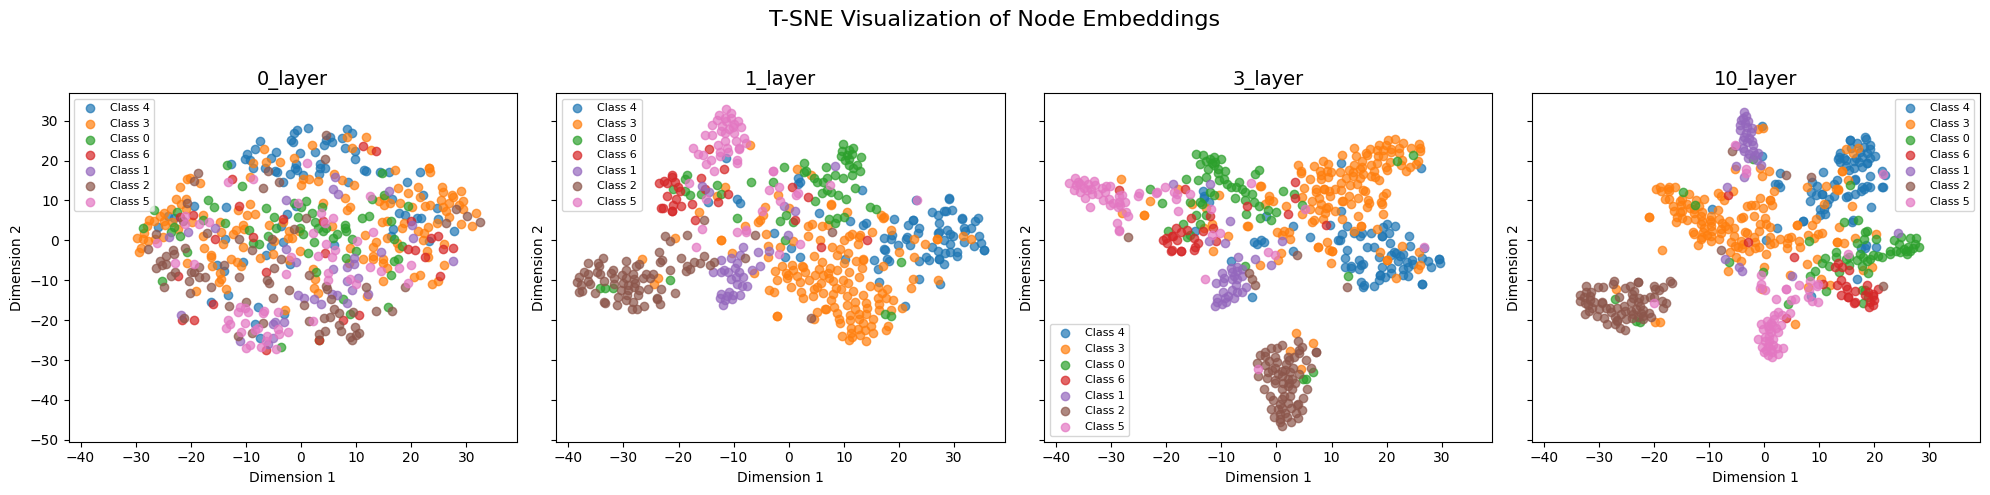

In [38]:
visualise(feature_dict)

**Possible Extensions**

- PairNorm
- DropEdge
